/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


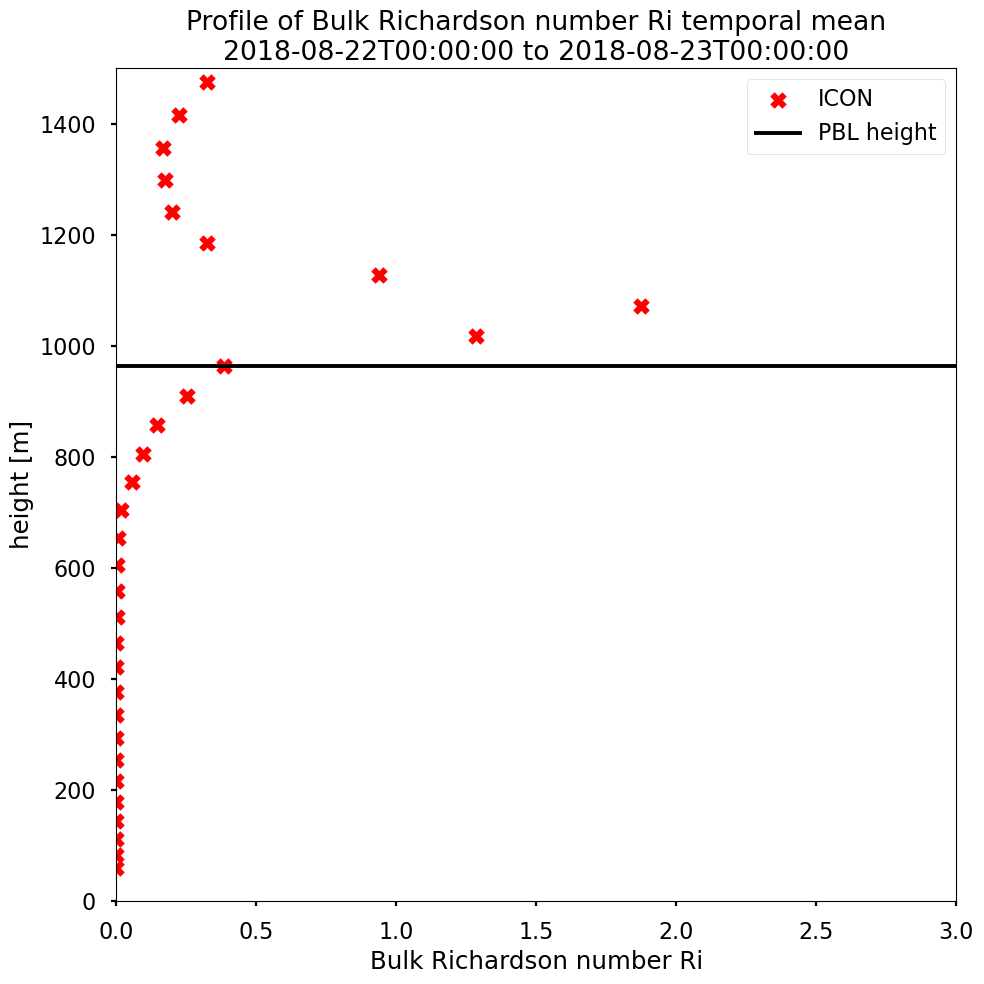

In [1]:
#For our analysis of the model data, we define the PBL height as the lowest
# level where the bulk Richardson number exceeds the value 0.28 (e.g. Richardson et al., 2013)
# (Heinze et al., 2017)

ouput_dir = "/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/master_plots/00_Ri/"

####

# Read in data for Iquique profiles:

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/Notebooks/")
from Sc_module import calc_Ri_bulk
plt.rc('font', size=12) 
plt.style.use('seaborn-poster')

file_icon = "/home/qwertz/data_js_icon_22_23_August_2018/stat_IQQ_all-times.nc"
file_hua22 = "/home/qwertz/obs_data_MA/iqq_foghat/22/sups_iqq_mwr00_l2_hua_p00_20180822000000.nc"
file_prw22 = "/home/qwertz/obs_data_MA/iqq_foghat/22/sups_iqq_mwr00_l2_prw_p00_20180822000000.nc"
file_00ta22 = "/home/qwertz/obs_data_MA/iqq_foghat/22/sups_iqq_mwr00_l2_ta_p00_20180822000000.nc"
file_BLta22 = "/home/qwertz/obs_data_MA/iqq_foghat/22/sups_iqq_mwrBL00_l2_ta_p00_20180822000243.nc"
file_hua23 = "/home/qwertz/obs_data_MA/iqq_foghat/23/sups_iqq_mwr00_l2_hua_p00_20180823000000.nc"
file_prw23 = "/home/qwertz/obs_data_MA/iqq_foghat/23/sups_iqq_mwr00_l2_prw_p00_20180823000000.nc"
file_00ta23 = "/home/qwertz/obs_data_MA/iqq_foghat/23/sups_iqq_mwr00_l2_ta_p00_20180823000000.nc"
file_BLta23 = "/home/qwertz/obs_data_MA/iqq_foghat/23/sups_iqq_mwrBL00_l2_ta_p00_20180823000753.nc"
file_wind22 = "/home/qwertz/obs_data_MA/iqq_lidar_halo/22/wind_vad-24_20180822.nc"
file_wind23 = "/home/qwertz/obs_data_MA/iqq_lidar_halo/23/wind_vad-24_20180823.nc"

ds_icon = xr.open_dataset(file_icon)
ds_hua = xr.open_mfdataset([file_hua22, file_hua23])# # absolute humidity kg m-3 rho
ds_prw = xr.open_mfdataset([file_prw22, file_prw23])# # atmosphere_mass_content_of_water_vapor kg m-2 IWV
ds_00ta = xr.open_mfdataset([file_00ta22, file_00ta23])# # T Kelvin
ds_BLta = xr.open_mfdataset([file_BLta22, file_BLta23])# # t Kelvin / less timesteps...
ds_wind = xr.open_mfdataset([file_wind22, file_wind23])# # t Kelvin / less timesteps...
#####
# Entfernen von doppelten Zeitpunkten:
ds_hua = ds_hua.drop_duplicates("time")
ds_prw = ds_prw.drop_duplicates("time")
ds_00ta = ds_00ta.drop_duplicates("time")
ds_BLta = ds_BLta.drop_duplicates("time")

##############################################################
# Icon Daten zu Profil:

ds_icon_reduced = ds_icon.isel(ncells=0).sel(time=slice(20180822.0, 20180824.0)).mean("time")

ris_icon = []
theta_s = ds_icon_reduced["theta_v"].values[199]
for i, level in enumerate(ds_icon_reduced["height"].values):
    theta_z = ds_icon_reduced["theta_v"].values[i]
    uz = ds_icon_reduced["u"].values[i]
    vz = ds_icon_reduced["v"].values[i]
    ris_icon.append(calc_Ri_bulk(theta_s, theta_z, uz, vz))
    if ris_icon[i-1]>0.28 and ris_icon[i]<0.28:
        pbl_height = ds_icon_reduced["z_mc"].values[i-1]
        # print(i,": Ri threshold level: ", ds_icon_reduced["z_mc"].values[i], " m")

plt.figure(figsize=(10,10))
plt.title("Profile of Bulk Richardson number Ri temporal mean\n2018-08-22T00:00:00 to 2018-08-23T00:00:00")
plt.scatter(ris_icon, ds_icon_reduced["z_mc"].values, label="ICON", marker="X", color="red")
plt.ylabel("height [m]")
plt.xlabel("Bulk Richardson number Ri")
plt.ylim(0,1500)
plt.xlim(0,3)
plt.axhline(pbl_height, color="black", label="PBL height")
plt.legend()
plt.tight_layout()
# plt.savefig(ouput_dir+"richardson_mean_profile.png")

##############################################################



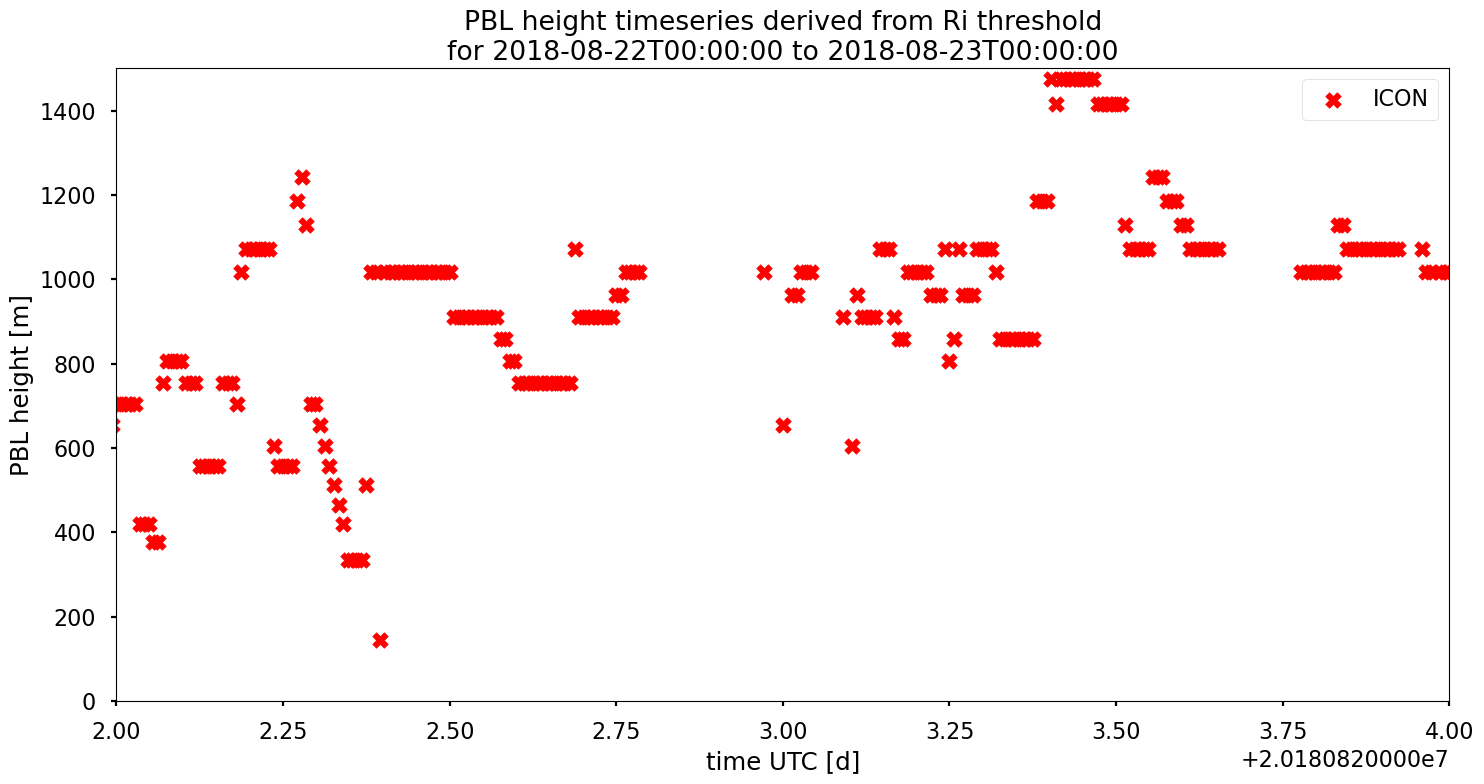

In [2]:
# Create timeseries of PBL heights depending on Ri

ds_icon_reduced = ds_icon.isel(ncells=0)
# print(ds_icon_reduced)

pbl_heights = []
for j, timestep in enumerate(ds_icon_reduced["time"].values):
    
    ris_icon = []
    theta_s = ds_icon_reduced["theta_v"].values[j, 199]
    pbl_height = np.nan
    for i, level in enumerate(ds_icon_reduced["height"].values):
        theta_z = ds_icon_reduced["theta_v"].values[j,i]
        uz = ds_icon_reduced["u"].values[j,i]
        vz = ds_icon_reduced["v"].values[j,i]
        ris_icon.append(calc_Ri_bulk(theta_s, theta_z, uz, vz))
        if ris_icon[i-1]>0.28 and ris_icon[i]<0.28:
            pbl_height = ds_icon_reduced["z_mc"].values[i-1]
    pbl_heights.append(pbl_height)


plt.figure(figsize=(15,8))
plt.title("PBL height timeseries derived from Ri threshold\nfor 2018-08-22T00:00:00 to 2018-08-23T00:00:00")
plt.scatter(ds_icon_reduced["time"].values, pbl_heights, label="ICON", marker="X", color="red")
plt.ylabel("PBL height [m]")
plt.xlabel("time UTC [d]")
plt.ylim(0,1500)
plt.xlim(20180822.0,20180824.0)
plt.legend()
plt.tight_layout()
# plt.savefig(ouput_dir+"richardson_timeseries.png")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(400, 194)
(400, 194)
(43, 181)
(43, 181)
(181, 43)


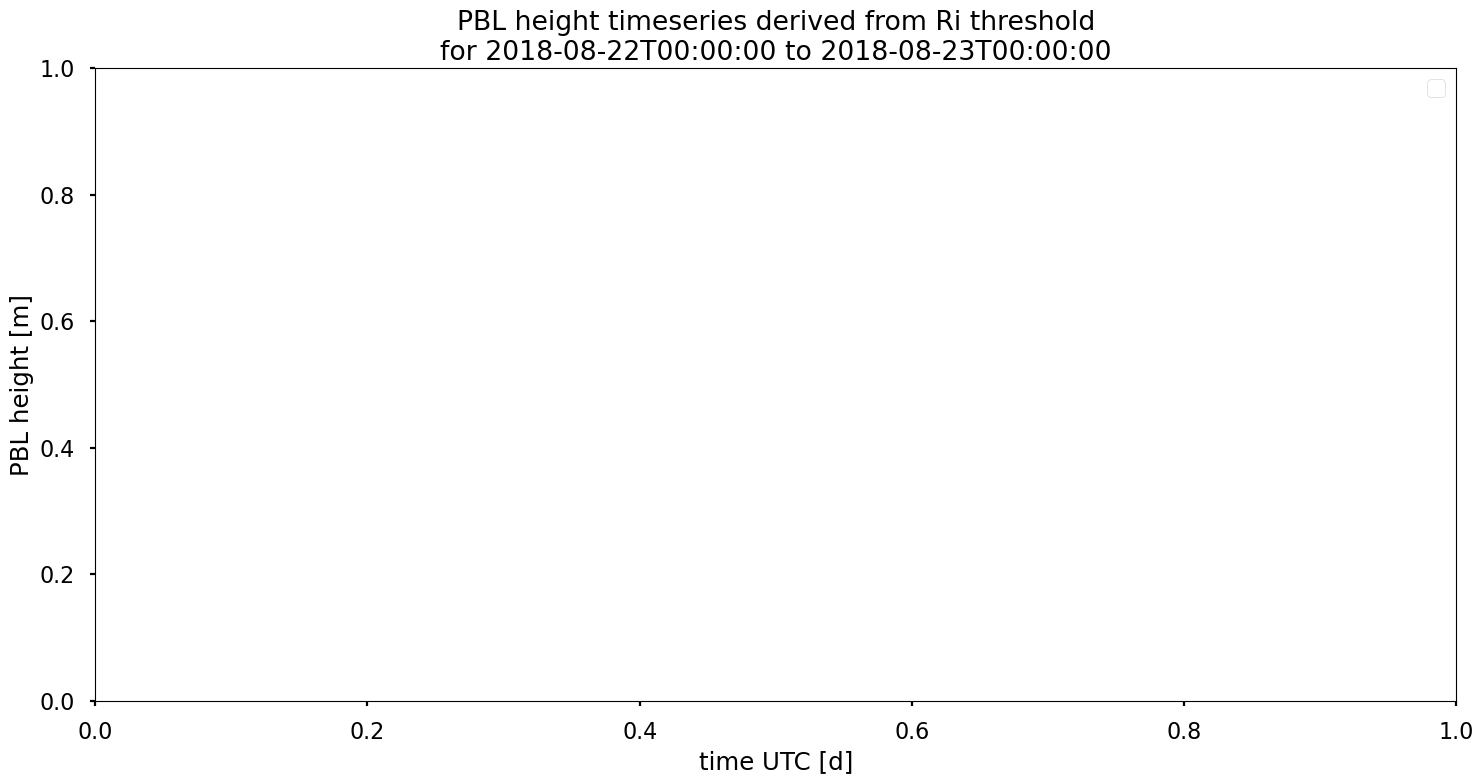

In [3]:
# Calculate PBL height timeseries depending on Foghat:

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import subprocess
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
import sys
sys.path.append("/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/Notebooks/")
from Sc_module import convert_to_float_timestamps

#########################################################

def convert_julian_to_datetime(julian_array):
    # Konvertiere den Julian-Tag in Unix-Zeitstempel
    unix_times = (julian_array - 2440587.5) * 86400
    
    # Konvertiere Unix-Zeitstempel in Datumszeichenfolgen im ISO-Format
    date_strings = []
    for unix_time in unix_times:
        command = f"date -ud '@{int(unix_time)}' +'%Y-%m-%d %H:%M:%S'"
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        if result.returncode == 0:
            date_strings.append(result.stdout.strip())
        else:
            raise ValueError("Fehler beim Konvertieren des Unix-Zeitstempels.")
    
    # Konvertiere Datumszeichenfolgen in np.datetime64-Objekte
    datetime_array = np.array(date_strings, dtype='datetime64')
    
    return datetime_array

##############################################################
# Foghat Daten zu Profil:
file_wind22 = "/home/qwertz/obs_data_MA/iqq_lidar_halo/22/wind_vad-24_20180822.nc"
file_wind23 = "/home/qwertz/obs_data_MA/iqq_lidar_halo/23/wind_vad-24_20180823.nc"
ds_wind = xr.open_mfdataset([file_wind22, file_wind23])# # t Kelvin / less timesteps...
ds_theta_v = xr.open_dataset("/home/qwertz/obs_data_MA/iqq_foghat/theta_v_iqq_22_23apschera20240214.nc")

#############################################
# scipy.interpolate.interp2d(x, y, z, kind='linear', copy=True, bounds_error=False, fill_value=None)
datetime_array = convert_julian_to_datetime(ds_wind["time"].values)
float_wind_time = convert_to_float_timestamps(datetime_array)

us_before_interp = ds_wind["wind_vec"].values[0,:,:]
vs_before_interp = ds_wind["wind_vec"].values[1,:,:]
print(np.shape(us_before_interp))
print(np.shape(vs_before_interp))
####################
#interp_func_u2d = interp2d( float_wind_time, ds_wind["height"].values,us_before_interp)
#interp_func_v2d = interp2d(float_wind_time,  ds_wind["height"].values, vs_before_interp)
rect_func_u2d = RectBivariateSpline( ds_wind["height"].values, float_wind_time, us_before_interp)
rect_func_v2d = RectBivariateSpline(ds_wind["height"].values,float_wind_time,   vs_before_interp)
#####################

us = rect_func_u2d(ds_theta_v["height"].values, convert_to_float_timestamps( ds_theta_v["time"].values))
vs = rect_func_v2d(ds_theta_v["height"].values, convert_to_float_timestamps( ds_theta_v["time"].values))
# us = interp_func_u2d(ds_theta_v["height"].values, convert_to_float_timestamps( ds_theta_v["time"].values))
# vs = interp_func_v2d( ds_theta_v["height"].values,convert_to_float_timestamps( ds_theta_v["time"].values))
print(np.shape(us))
print(np.shape(vs))
print(np.shape(ds_theta_v["theta_v"].values))

###############################################

pbl_heights_foghat = []
for j, timestep in enumerate(ds_theta_v["time"].values):
    ris_foghat = []
    theta_s = ds_theta_v["theta_v"].values[j, 0]
    pbl_height = np.nan
    for i, level in enumerate(ds_theta_v["height"].values):
        theta_z = ds_theta_v["theta_v"].values[j,i]
        uz = us[j,i]
        vz = vs[j,i]
        # print("Inputs: surface:", theta_s," theta z: ", theta_z, " u: ", uz," v: ", vz)
        ris_foghat.append(calc_Ri_bulk(theta_s, theta_z, uz, vz))
        if 0.28>ris_foghat[i-1] and ris_foghat[i]>0.28:
            pbl_height = ds_foghat_reduced["height"].values[i]
    pbl_heights_foghat.append(pbl_height)

    ####################
    if j==5:
        break
        ###########

#########################

plt.figure(figsize=(15,8))
plt.title("PBL height timeseries derived from Ri threshold\nfor 2018-08-22T00:00:00 to 2018-08-23T00:00:00")
########################
# This leads to error: ValueError: x and y must be the same size
# plt.scatter(ds_theta_v["time"].values, pbl_heights_foghat , label="Foghat", marker="X", color="blue")
##########################
plt.ylabel("PBL height [m]")
plt.xlabel("time UTC [d]")
# plt.ylim(0,1500)
# plt.xlim(20180822.0,20180824.0)
plt.legend()
plt.tight_layout()
# plt.savefig(ouput_dir+"richardson_timeseries.png")

############################################################################

# My Theta_v values for the Ri calcualtion are probably to low. I should check out Jan's advices...
# 


In [4]:
# Create statistic of PBL heights depending on Ri for both timeseries

import xarray as xr
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt

icon_pfad = "/home/qwertz/data_js_icon_22_23_August_2018/"

ds_xz_sect22 = xr.open_dataset(icon_pfad+"cloud_DOM01_ML_20180822_all.lat_2141.xz-sect.nc") 
ds_xz_sect23 = xr.open_dataset(icon_pfad+"cloud_DOM01_ML_20180823_all.lat_2141.xz-sect.nc") 
ds_lat2141 = xr.concat([ds_xz_sect22,ds_xz_sect23], dim="time")

print(ds_lat2141)

<xarray.Dataset> Size: 4GB
Dimensions:      (time: 288, ncells: 2236, vertices: 3, height: 200, bnds: 2,
                  height_2: 201)
Coordinates:
  * time         (time) float64 2kB 2.018e+07 2.018e+07 ... 2.018e+07 2.018e+07
    clon         (ncells) float32 9kB -1.243 -1.243 -1.243 ... -1.194 -1.194
    clat         (ncells) float32 9kB -0.3739 -0.3739 ... -0.3738 -0.3737
  * height       (height) float64 2kB 1.0 2.0 3.0 4.0 ... 198.0 199.0 200.0
  * height_2     (height_2) float64 2kB 1.0 2.0 3.0 4.0 ... 199.0 200.0 201.0
Dimensions without coordinates: ncells, vertices, bnds
Data variables:
    clon_bnds    (time, ncells, vertices) float32 8MB -1.243 -1.243 ... -1.194
    clat_bnds    (time, ncells, vertices) float32 8MB -0.3739 ... -0.3736
    height_bnds  (time, height, bnds) float64 922kB 1.0 2.0 2.0 ... 200.0 201.0
    qv           (time, height, ncells) float32 515MB 2.374e-06 ... 0.002231
    qc           (time, height, ncells) float32 515MB 0.0 0.0 0.0 ... 0.0 0.0
    u

In [5]:
# Calculate mean Ri profile for Foghat and ICON in comparison:

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import subprocess
from scipy.interpolate import interp1d
import sys
sys.path.append("/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/Notebooks/")
from Sc_module import convert_to_float_timestamps
from Sc_module import convert_single_timestamp
from Sc_module import calc_Ri_bulk

#########################################################

def convert_julian_to_datetime(julian_array):
    # Konvertiere den Julian-Tag in Unix-Zeitstempel
    unix_times = (julian_array - 2440587.5) * 86400
    
    # Konvertiere Unix-Zeitstempel in Datumszeichenfolgen im ISO-Format
    date_strings = []
    for unix_time in unix_times:
        command = f"date -ud '@{int(unix_time)}' +'%Y-%m-%d %H:%M:%S'"
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        if result.returncode == 0:
            date_strings.append(result.stdout.strip())
        else:
            raise ValueError("Fehler beim Konvertieren des Unix-Zeitstempels.")
    
    # Konvertiere Datumszeichenfolgen in np.datetime64-Objekte
    datetime_array = np.array(date_strings, dtype='datetime64')
    
    return datetime_array

##############################################################

def plot_average_Ri_profile(begin_float=20180822.0, end_float=20180824.0):
    datetime_begin = str(convert_single_timestamp(begin_float))[:19]
    datetime_end = str(convert_single_timestamp(end_float))[:19]
    
    # Icon:
    file_icon = "/home/qwertz/data_js_icon_22_23_August_2018/stat_IQQ_all-times.nc"
    ds_icon = xr.open_dataset(file_icon)
    
    # Foghat Daten zu Profil:
    ds_theta_v4 = xr.open_dataset("/home/qwertz/obs_data_MA/iqq_foghat/theta_v_spec_hum_iqq_22_23apschera20240304.nc")
    file_wind22 = "/home/qwertz/obs_data_MA/iqq_lidar_halo/22/wind_vad-24_20180822.nc"
    file_wind23 = "/home/qwertz/obs_data_MA/iqq_lidar_halo/23/wind_vad-24_20180823.nc"
    ds_wind = xr.open_mfdataset([file_wind22, file_wind23])# # t Kelvin / less timesteps...
    ds_foghat_reduced4 = ds_theta_v4.sel(time=slice(datetime_begin, datetime_end)).mean("time")
    datetime_array = convert_julian_to_datetime(ds_wind["time"].values)
    ds_wind = ds_wind.assign_coords(time=("time", datetime_array))
    
    #####################################################################################################
    # Interpolation of wind lidar to Foghat height levels:
    interp_func_u = interp1d(ds_wind["height"].values,\
                           np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[0,:])
    interp_func_v = interp1d(ds_wind["height"].values,\
                           np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[1,:])
    us = interp_func_u(ds_foghat_reduced4["height"].values[1:])
    vs = interp_func_v(ds_foghat_reduced4["height"].values[1:])
    
    ###########################
    # Derive Ris and PBL heights:
    pbl_height4 = np.nan
    ris_foghat4 = []
    theta_s4 = ds_foghat_reduced4["theta_v"].values[0]
    switch =False
    windswitch = False
    for i, level in enumerate(ds_foghat_reduced4["height"].values):
        if i==len(ds_foghat_reduced4["height"].values)-1:
            break
        theta_z4 = ds_foghat_reduced4["theta_v"].values[i]
        ########
        if i==0:
            uz = us[i]
            vz = vs[i]
        elif np.isnan(us[i-1]) and np.isnan(vs[i-1]):
            # print("No wind data for: ",i, level)
            # print("consider u v constant...")
            if not windswitch:
                firstlevel = i
                windswitch = True
        else:
            uz = us[i-1]
            vz = vs[i-1]
        # print("Level: ", level, " m - theta surface:", theta_s4," theta z: ", theta_z4, " u: ", uz," v: ", vz)
        #######
        ris_foghat4.append(calc_Ri_bulk(theta_s4, theta_z4, uz, vz))
        if 0.28>ris_foghat4[i-1] and ris_foghat4[i]>0.28 and not switch:
            pbl_height4 = ds_foghat_reduced4["height"].values[i]
            switch = True


    # Derive ICON profile:
    ds_icon_reduced = ds_icon.isel(ncells=0).sel(time=slice(begin_float, end_float)).mean("time")
    
    ris_icon = []
    theta_s = ds_icon_reduced["theta_v"].values[199]
    for i, level in enumerate(ds_icon_reduced["height"].values):
        theta_z = ds_icon_reduced["theta_v"].values[i]
        uz = ds_icon_reduced["u"].values[i]
        vz = ds_icon_reduced["v"].values[i]
        ris_icon.append(calc_Ri_bulk(theta_s, theta_z, uz, vz))
        if ris_icon[i-1]>0.28 and ris_icon[i]<0.28:
            pbl_height = ds_icon_reduced["z_mc"].values[i-1]
            # print(i,": Ri threshold level: ", ds_icon_reduced["z_mc"].values[i], " m")
    
    plt.figure(figsize=(12,8))
    plt.title("Profile of Bulk Richardson number Ri temporal mean\n"+str(datetime_begin)+" to "+str(datetime_end))
    plt.plot(ris_icon, ds_icon_reduced["z_mc"].values, label="ICON", marker="X", color="red")
    plt.plot(ris_foghat4[:firstlevel], ds_foghat_reduced4["height"].values[:firstlevel], label="Foghat", marker="X", color="blue")
    plt.plot(ris_foghat4[firstlevel-1:], ds_foghat_reduced4["height"].values[firstlevel-1:-1],\
             label="Foghat - horizontal wind estimated constant",\
             marker="o",linestyle="dotted", color="blue")
    plt.ylabel("height [m]")
    plt.xlabel("Bulk Richardson number Ri")
    plt.ylim(0,1300)
    plt.xlim(-0.2,1.5)
    # plt.axvline(0, color="black", alpha=0.4)
    plt.axhline(pbl_height, color="black", label="PBL height by Ri threshold")
    plt.axhline(pbl_height4, color="black")
    plt.legend()
    plt.tight_layout()
    plt.savefig(ouput_dir+str(datetime_begin)+"_"+str(datetime_end)+"richardson_mean_profile.png")
    plt.close()

    return 0

#########################################################################
# Nun stimmen die Höhen wieder, aber unser WInd time mean, ohne Nanmean, führt vermutlich zu so vielen Nanwerten in der Höhe...XXX
# Ne, daran lag's nicht...XXX

t_values_hourly = [20180822.0, 20180822.0+1/24, 20180822.0+2/24, 20180822.0+3/24, 20180822.0+4/24, 20180822.0+5/24, 20180822.0+6/24,\
                   20180822.0+7/24, 20180822.0+8/24, 20180822.0+9/24, 20180822.0+10/24, 20180822.0+11/24, 20180822.0+12/24,\
                   20180822.0+13/24, 20180822.0+14/24, 20180822.0+15/24,20180822.0+16/24,20180822.0+17/24,20180822.0+18/24,\
                   20180822.0+19/24,20180822.0+20/24,20180822.0+21/24,20180822.0+22/24, 20180822.0+23/24,\
                   20180823.0, 20180823.0+1/24, 20180823.0+2/24,20180823.0+3/24,20180823.0+4/24, 20180823.0+5/24,\
                   20180823.0+6/24, 20180823.0+7/24, 20180823.0+8/24, 20180823.0+9/24, 20180823.0+10/24, 20180823.0+11/24,\
                   20180823.0+12/24, 20180823.0+13/24, 20180823.0+14/24, 20180823.0+15/24, 20180823.0+16/24,\
                   20180823.0+17/24, 20180823.0+18/24, 20180823.0+19/24, 20180823.0+20/24,20180823.0+21/24, 20180823.0+22/24,\
                   20180823.0+23/24, 20180824, 20180822.0,20180824]

for i, timestep in enumerate(t_values_hourly):
    if i+1==len(t_values_hourly):
        break
    if t_values_hourly[i+1]<timestep:
        print("overleaped timestep: ", timestep, " to ", t_values_hourly[i+1])
        continue
    begin_float = timestep
    end_float = t_values_hourly[i+1]
    plot_average_Ri_profile(begin_float=begin_float, end_float=end_float)

    #####################
    if i==2:
        break
        print("Stopped trial run early. Remove if statement for whole processing")
    

/tmp/ipykernel_10627/2484902817.py:52: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_wind = ds_wind.assign_coords(time=("time", datetime_array))
/tmp/ipykernel_10627/2484902817.py:57: RuntimeWarning: Mean of empty slice
  np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[0,:])
/tmp/ipykernel_10627/2484902817.py:59: RuntimeWarning: Mean of empty slice
  np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[1,:])
/tmp/ipykernel_10627/2484902817.py:52: UserWarning: Converting non-nanosecond precision datetime values 

Windspeed from Amdar is assumed to be in kt!!!


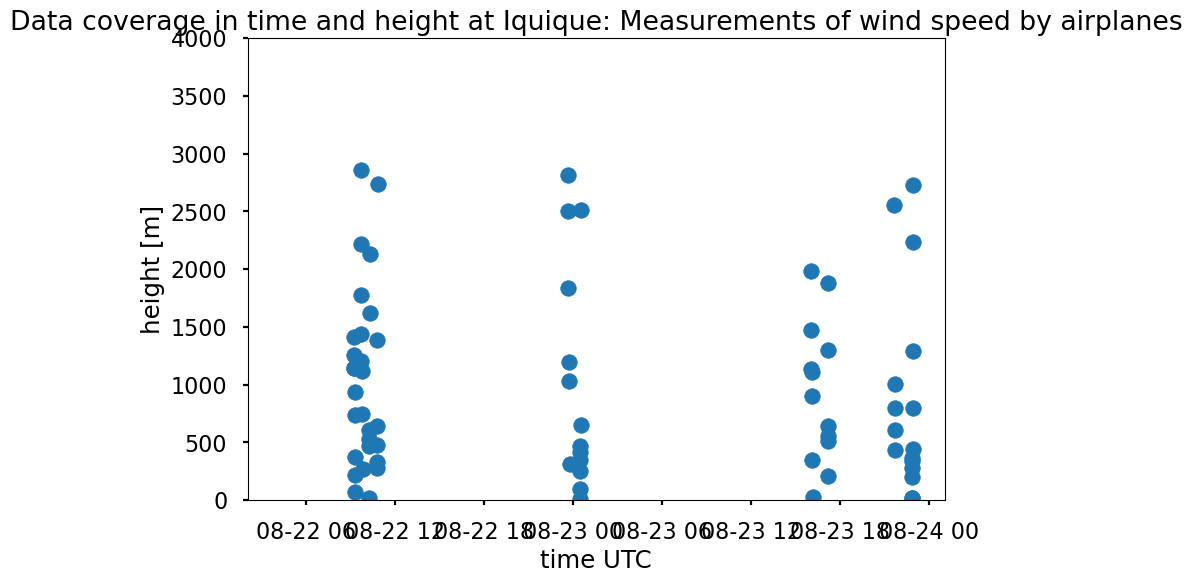

In [6]:
# Einlesen neuer Winddaten von Amdar / GSD / IQQ:

import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import glob
import numpy as np
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
import sys
sys.path.append("/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/Notebooks/")
from Sc_module import convert_to_float_timestamps
from Sc_module import convert_single_timestamp

###########################################

def read_pandas_dataframe_from_html(filepath):
    html_table = open(filepath,"r").read()
    
    soup = BeautifulSoup(html_table, 'html.parser')
    
    # Die Daten aus der Tabelle extrahieren
    data = []
    for row in soup.find_all('tr'):
        row_data = []
        for cell in row.find_all(['th', 'td']):
            row_data.append(cell.get_text(strip=True))
        data.append(row_data)
    columns = data[0] # Die Spaltenüberschriften festlegen
    data = data[1:] # Die Daten ohne die Spaltenüberschriften extrahieren
    df = pd.DataFrame(data, columns=columns) # DataFrame erstellen

    return df

#######################################################
# DMC wind:

pfad_dmc = "/home/qwertz/obs_data_MA/amdar/dmc/"
dmc_files = ["dmc_amdar_20180822_150km.txt", "dmc_amdar_20180822.txt", "dmc_amdar_20180823.txt"]

df_dmc22_150 = read_pandas_dataframe_from_html(pfad_dmc+dmc_files[0])
df_dmc22 = read_pandas_dataframe_from_html(pfad_dmc+dmc_files[1])
df_dmc23  = read_pandas_dataframe_from_html(pfad_dmc+dmc_files[2])

##########################

def add_datetimes2dataframe(df, datetstring="2018-08-22T"):
    # Add timestamps:
    datetimes = []
    for timestring in df["Hora"].values:
        datetime = np.datetime64(datetstring+timestring+":00")
        datetimes.append(datetime)

    df["datetime"] = datetimes
    return df

##########################

print("Windspeed from Amdar is assumed to be in kt!!!")

def convert_deg_speed2uv_wind(df):
    # kt => m/s (???)
    us = []
    vs = []
    for direction, speed in zip(df["Direccion Viento"].values, df["Intensidad Viento"].values):
        ui = float(speed) * np.sin(np.deg2rad(float(direction))) * 0.5144444
        vi = float(speed) * np.cos(np.deg2rad(float(direction))) * 0.5144444
        us.append(ui)
        vs.append(vi)
        
    df["u"] = us
    df["v"] = vs
    return df

##########################
# Add datetimes:
df_dmc22 = add_datetimes2dataframe(df_dmc22, datetstring="2018-08-22T")
df_dmc23 = add_datetimes2dataframe(df_dmc23, datetstring="2018-08-23T")

# print(df_dmc23["Presion"])

###
# Convert wind:
df_dmc22 = convert_deg_speed2uv_wind(df_dmc22)
df_dmc23 = convert_deg_speed2uv_wind(df_dmc23)

###
# Erzeuge Windprofile für Plots: maximale Distanz 30 km; maximale Höhe: 3000 m
df_completa = pd.concat([df_dmc22, df_dmc23])
df_completa["Altitud"] = df_completa["Altitud"].astype(float)
df_completa.sort_values(by='datetime', inplace=True)
for i, value in enumerate(df_completa["Distancia Mts"].values):
    df_completa["Distancia Mts"].values[i] = value.replace(",", ".")
df_completa["Distancia Mts"] = df_completa["Distancia Mts"].astype(float)
# df_filtered1 = df_completa[df_completa["Altitud"] <= 3000]
df_filtered = df_completa[df_completa["Distancia Mts"] <= 30]

####
plt.figure(figsize=(9,6))
plt.title("Data coverage in time and height at Iquique: Measurements of wind speed by airplanes")
plt.xlabel("time UTC")
plt.ylabel("height [m]")
plt.scatter(df_filtered["datetime"].values, df_filtered["Altitud"].values)
plt.ylim(0,4000)
plt.savefig(ouput_dir+"AMDAR_datacoverage.png")
###
# Unterteile dies in 4 Profile
df_profile1 = df_filtered[df_filtered["datetime"] < np.datetime64('2018-08-22T11:00:00.000000000')]
df_profile2 = df_filtered[(np.datetime64('2018-08-22T11:00:00.000000000') < df_filtered["datetime"]) &\
    (df_filtered["datetime"] < np.datetime64('2018-08-23T01:00:00.000000000'))]
df_profile3 = df_filtered[(np.datetime64('2018-08-23T01:00:00.0') < df_filtered["datetime"]) &\
    (df_filtered["datetime"]< np.datetime64('2018-08-23T17:17:00.000000000'))]
df_profile4 = df_filtered[(np.datetime64('2018-08-23T21:00:00.000000000') < df_filtered["datetime"]) &\
    (df_filtered["datetime"]< np.datetime64('2018-08-23T23:50:00.000000000'))]

###

#######################################################
# Pfad: /home/qwertz/obs_data_MA/amdar/
# Dateien:
# dataAMDAR_ricardo_munoz_de.htm
#  datosAMDAR_ricardo_munoz.htm



In [7]:
# 4 Plots für 4 Profile:
##############################################################

import xarray as xr
from scipy.interpolate import interp1d
from Sc_module import write_sounding_string

#####################################################################

def convert_single_datatime2float(ts):
    ts_str = str(ts)
    day_str = ts_str[:10]
    hour = int(ts_str[11:13])
    minute = int(ts_str[14:16])
    second = int(ts_str[17:19])
    try:
        microsecond = int("0."+ts_str[20:])
    except:
        microsecond = 0.
                
    # Berechnung des Float-Zeitstempels
    float_ts = float(day_str[:4])*10000+float(day_str[5:7])*100+float(day_str[8:10]) + \
                       (hour * 3600 + minute * 60 + second + microsecond) / 86400
    return float_ts

#####################################################################

def plot_average_Ri_profile(begin_float=20180822.0, end_float=20180824.0, wind_df="", maxlevel=23):
    datetime_begin = str(convert_single_timestamp(begin_float))[:19]
    datetime_end = str(convert_single_timestamp(end_float))[:19]
    
    # Icon:
    file_icon = "/home/qwertz/data_js_icon_22_23_August_2018/stat_IQQ_all-times.nc"
    ds_icon = xr.open_dataset(file_icon)
    
    # Foghat Daten zu Profil:
    ds_theta_v4 = xr.open_dataset("/home/qwertz/obs_data_MA/iqq_foghat/theta_v_spec_hum_iqq_22_23apschera20240304.nc")
    file_wind22 = "/home/qwertz/obs_data_MA/iqq_lidar_halo/22/wind_vad-24_20180822.nc"
    file_wind23 = "/home/qwertz/obs_data_MA/iqq_lidar_halo/23/wind_vad-24_20180823.nc"
    ds_wind = xr.open_mfdataset([file_wind22, file_wind23])# # t Kelvin / less timesteps...
    ds_foghat_reduced4 = ds_theta_v4.sel(time=slice(datetime_begin, datetime_end)).mean("time")
    datetime_array = convert_julian_to_datetime(ds_wind["time"].values)
    ds_wind = ds_wind.assign_coords(time=("time", datetime_array))


    print("Hier wollte ich mal Feuchteprofile hinzufügen...")
    '''
    file_hua22 = "/home/qwertz/obs_data_MA/iqq_foghat/22/sups_iqq_mwr00_l2_hua_p00_20180822000000.nc"
    file_hua23 = "/home/qwertz/obs_data_MA/iqq_foghat/23/sups_iqq_mwr00_l2_hua_p00_20180823000000.nc"
    ds_hua22 = xr.open_dataset(file_hua22)
    ds_hua23 = xr.open_dataset(file_hua23)
    ds_hua = xr.concat([ds_hua22, ds_hua23], dim="time") # absolute humidity kg m-3 rho
    # feuchte_iqq = ds_hua["hua"].sel(time=slice(datetime_begin, datetime_end)).mean(dim="time")
    '''

    ######################################################
    # Interpolation of wind lidar to Foghat height levels:
    interp_func_u = interp1d(ds_wind["height"].values,\
                           np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[0,:])
    interp_func_v = interp1d(ds_wind["height"].values,\
                           np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[1,:])
    us = interp_func_u(ds_foghat_reduced4["height"].values[1:])
    vs = interp_func_v(ds_foghat_reduced4["height"].values[1:])

    #######################################################
    # Interpolation of airplane data to Foghat height levels:
    interp_func_u = interp1d(wind_df["Altitud"].values, wind_df["u"].values)
    interp_func_v = interp1d(wind_df["Altitud"].values, wind_df["v"].values)
    us_plane = interp_func_u(ds_foghat_reduced4["height"].values[1:maxlevel])
    vs_plane = interp_func_v(ds_foghat_reduced4["height"].values[1:maxlevel])
    
    ###########################
    # Derive Ris and PBL heights:
    pbl_height4 = np.nan
    ris_foghat4 = []
    us_complete =[]
    vs_complete =[]
    theta_s4 = ds_foghat_reduced4["theta_v"].values[0]
    switch =False
    windswitch = False
    for i, level in enumerate(ds_foghat_reduced4["height"].values[:maxlevel]):
        if i==len(ds_foghat_reduced4["height"].values)-1:
            break
        theta_z4 = ds_foghat_reduced4["theta_v"].values[i]
        ########
        if i==0:
            uz = us[i]
            vz = vs[i]
        elif np.isnan(us[i-1]) and np.isnan(vs[i-1]):
            uz = us_plane[i-1]
            vz = vs_plane[i-1]
            if not windswitch:
                firstlevel = i
                windswitch = True
        else:
            uz = us[i-1]
            vz = vs[i-1]
        # print("Level: ", level, " m - theta surface:", theta_s4," theta z: ", theta_z4, " u: ", uz," v: ", vz)
        #######
        ris_foghat4.append(calc_Ri_bulk(theta_s4, theta_z4, uz, vz))
        us_complete.append(uz)
        vs_complete.append(vz)
        if 0.28>ris_foghat4[i-1] and ris_foghat4[i]>0.28 and not switch:
            pbl_height4 = ds_foghat_reduced4["height"].values[i]
            switch = True


    ################################
    # Write a wind dataset here:

    us_complete = np.reshape(us_complete, (1,23))
    vs_complete = np.reshape(vs_complete, (1,23))
    print("len(uz) : ",len(us_complete))
    print("len(vz) : ",len(vs_complete))
    print("len(ds_foghat_reduced4[].values[:maxlevel]) : ",len(ds_foghat_reduced4["height"].values[:maxlevel]))
    print("len(np.array([datetime_begin])) : ",len(np.array([datetime_begin])))
    new_file = "/home/qwertz/obs_data_MA/wind_iqq_22_23apschera20240304"+datetime_begin+".nc"
    ds_wind = xr.Dataset({"u": (("time", "height"), us_complete),"v": (("time","height"), vs_complete),},\
                        coords={"time": np.array([datetime_begin]),"height": ds_foghat_reduced4["height"].values[:maxlevel],})
    ds_wind.to_netcdf(new_file)
    ###########################
    
    # Derive ICON profile:
    ds_icon_reduced = ds_icon.isel(ncells=0).sel(time=slice(begin_float, end_float)).mean("time")
    
    ris_icon = []
    theta_s = ds_icon_reduced["theta_v"].values[199]
    for i, level in enumerate(ds_icon_reduced["height"].values):
        theta_z = ds_icon_reduced["theta_v"].values[i]
        uz = ds_icon_reduced["u"].values[i]
        vz = ds_icon_reduced["v"].values[i]
        ris_icon.append(calc_Ri_bulk(theta_s, theta_z, uz, vz))
        if ris_icon[i-1]>0.28 and ris_icon[i]<0.28:
            pbl_height = ds_icon_reduced["z_mc"].values[i-1]
            # print(i,": Ri threshold level: ", ds_icon_reduced["z_mc"].values[i], " m")

    #### Write sounding for UCLA inputs:
    write_sounding_string(ps=ds_foghat_reduced4["p"].values[0], zs=ds_foghat_reduced4["height"].values,\
                          Thetas=ds_foghat_reduced4["theta_l"].values,\
                          qs=(ds_foghat_reduced4["q"].values)*1000, us=np.concatenate((us[:firstlevel-1],us_plane[firstlevel:])),\
                          vs=np.concatenate((vs[:firstlevel-1],vs_plane[firstlevel:])), zmax=5000,
                         filename = "sound_in_IQQ"+str(datetime_begin))

    plt.title("Profile of Bulk Richardson Number in Iquique\n betweeen "+str(datetime_begin)+" and "+str(datetime_end))
    plt.plot(ris_icon, ds_icon_reduced["z_mc"].values, label="ICON", marker="X", color="red")
    plt.plot(ris_foghat4[:firstlevel], ds_foghat_reduced4["height"].values[:firstlevel],\
                label="Foghat - Wind data by Lidar", marker="X", color="blue")
    plt.plot(ris_foghat4[firstlevel-1:], ds_foghat_reduced4["height"].values[firstlevel-1:maxlevel],\
             label="Foghat - Wind data by AMDAR",\
             marker="o",linestyle="dotted", color="blue")
    plt.ylabel("height [m]", fontsize=12) 
    plt.xlabel("Bulk Richardson number Ri", fontsize=12) 
    plt.ylim(0,1500)
    plt.xlim(-0.2,1.5)
    # plt.axvline(0, color="black", alpha=0.4)
    plt.axhline(pbl_height, color="black", label="PBL height by Ri threshold")
    plt.axhline(pbl_height4, color="black")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(ouput_dir+str(datetime_begin)+"_"+str(datetime_end)+"Ri_mean_profile.png",\
                facecolor="white")
    plt.close()

    
    # Establish Subplots:
    fig, axs = plt.subplots(1,3, figsize=(15,9))
    fig.suptitle("Atmospheric profiles in Iquique\n betweeen "+str(datetime_begin)+" and "+str(datetime_end))

    # First panel:
    axs[0].set_title("Bulk Richardson Number")
    axs[0].plot(ris_icon, ds_icon_reduced["z_mc"].values, label="ICON", marker="X", color="red")
    axs[0].plot(ris_foghat4[:firstlevel], ds_foghat_reduced4["height"].values[:firstlevel],\
                label="Foghat - Wind data by Lidar", marker="X", color="blue")
    axs[0].plot(ris_foghat4[firstlevel-1:], ds_foghat_reduced4["height"].values[firstlevel-1:maxlevel],\
             label="Foghat - Wind data by AMDAR",\
             marker="o",linestyle="dotted", color="blue")
    axs[0].set_ylabel("height [m]", fontsize=12) 
    axs[0].set_xlabel("Bulk Richardson number Ri", fontsize=12) 
    axs[0].set_ylim(0,1500)
    axs[0].set_xlim(-0.2,1.5)
    # plt.axvline(0, color="black", alpha=0.4)
    axs[0].axhline(pbl_height, color="black", label="PBL height by Ri threshold")
    axs[0].axhline(pbl_height4, color="black")
    axs[0].legend(loc="lower right")

    # 2nd Panel: Theta
    axs[1].set_title("Virtual Potential Temperature $\Theta_v$")
    axs[1].plot(ds_foghat_reduced4["theta_v"].values, ds_foghat_reduced4["height"].values, color="blue", label="Foghat")
    axs[1].plot(ds_icon_reduced["theta_v"].values, ds_icon_reduced["z_mc"].values, color="red", label="ICON")
    axs[1].set_ylabel("height [m]", fontsize=12) 
    axs[1].set_xlabel("Theta", fontsize=12) 
    axs[1].set_ylim(0,1500)
    axs[1].set_xlim(280, 320)
    axs[1].legend()    
    
    # 3rd Panel: Wind
    wind_lidar = np.linalg.norm([us, vs], axis=0)
    wind_plane = np.linalg.norm([us_plane, vs_plane], axis=0)
    wind_icon = np.linalg.norm([ds_icon_reduced["u"].values, ds_icon_reduced["v"].values], axis=0)
    axs[2].set_title("Wind speed")
    axs[2].plot(wind_lidar, ds_foghat_reduced4["height"].values[1:], label="Lidar", color= "blue")
    axs[2].plot(wind_plane, ds_foghat_reduced4["height"].values[1:maxlevel], label="AMDAR", color="blue", linestyle="dashed")
    axs[2].plot(wind_icon, ds_icon_reduced["z_mc"].values, label="ICON", color= "red")
    axs[2].set_ylabel("height [m]", fontsize=12) 
    axs[2].set_xlabel("wind speed [m/s]", fontsize=12) 
    axs[2].set_ylim(0,1500)
    axs[2].set_xlim(0,8)
    axs[2].legend()    

    # Save
    plt.tight_layout()
    plt.savefig(ouput_dir+str(datetime_begin)+"_"+str(datetime_end)+"richardson_multipanel.png",\
                facecolor="white")
    plt.close()
    
    return ris_icon, ds_icon_reduced["z_mc"].values, ris_foghat4, ds_foghat_reduced4["height"].values,\
    ris_foghat4, ds_foghat_reduced4["height"].values, ds_foghat_reduced4["theta_v"].values, wind_lidar, wind_plane

################################################################################
#print(convert_single_datatime2float(np.datetime64("2018-08-22T09:13:00")))
#print(convert_single_datatime2float(np.datetime64("2018-08-22T10:50:00")))

plot_average_Ri_profile(begin_float=convert_single_datatime2float(np.datetime64("2018-08-22T09:13:00")),\
                        end_float=convert_single_datatime2float(np.datetime64("2018-08-22T10:50:00")), wind_df=df_profile1)
plot_average_Ri_profile(begin_float=convert_single_datatime2float(np.datetime64("2018-08-22T23:38:00")),\
                        end_float=convert_single_datatime2float(np.datetime64("2018-08-23T00:33:00")), wind_df=df_profile2)
plot_average_Ri_profile(begin_float=convert_single_datatime2float(np.datetime64("2018-08-23T16:02:00")),\
                        end_float=convert_single_datatime2float(np.datetime64("2018-08-23T17:13:00")), wind_df=df_profile3)
plot_average_Ri_profile(begin_float=convert_single_datatime2float(np.datetime64("2018-08-23T21:38:00")),\
                        end_float=convert_single_datatime2float(np.datetime64("2018-08-23T22:57:00")), wind_df=df_profile4);

################################################################################
# Mache Panel mit Theta_v und WIndprofilen, um die Ursachen aufzudecken!XXX




/tmp/ipykernel_10627/1392809124.py:43: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_wind = ds_wind.assign_coords(time=("time", datetime_array))
/tmp/ipykernel_10627/1392809124.py:48: RuntimeWarning: Mean of empty slice
  np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[0,:])
/tmp/ipykernel_10627/1392809124.py:50: RuntimeWarning: Mean of empty slice
  np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[1,:])


len(uz) :  1
len(vz) :  1
len(ds_foghat_reduced4[].values[:maxlevel]) :  23
len(np.array([datetime_begin])) :  1


/tmp/ipykernel_10627/1392809124.py:43: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_wind = ds_wind.assign_coords(time=("time", datetime_array))
/tmp/ipykernel_10627/1392809124.py:48: RuntimeWarning: Mean of empty slice
  np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[0,:])
/tmp/ipykernel_10627/1392809124.py:50: RuntimeWarning: Mean of empty slice
  np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[1,:])


len(uz) :  1
len(vz) :  1
len(ds_foghat_reduced4[].values[:maxlevel]) :  23
len(np.array([datetime_begin])) :  1


/tmp/ipykernel_10627/1392809124.py:43: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_wind = ds_wind.assign_coords(time=("time", datetime_array))
/tmp/ipykernel_10627/1392809124.py:48: RuntimeWarning: Mean of empty slice
  np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[0,:])
/tmp/ipykernel_10627/1392809124.py:50: RuntimeWarning: Mean of empty slice
  np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[1,:])


len(uz) :  1
len(vz) :  1
len(ds_foghat_reduced4[].values[:maxlevel]) :  23
len(np.array([datetime_begin])) :  1


/tmp/ipykernel_10627/1392809124.py:43: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_wind = ds_wind.assign_coords(time=("time", datetime_array))
/tmp/ipykernel_10627/1392809124.py:48: RuntimeWarning: Mean of empty slice
  np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[0,:])
/tmp/ipykernel_10627/1392809124.py:50: RuntimeWarning: Mean of empty slice
  np.nanmean(ds_wind["wind_vec"].sel(time=slice(datetime_begin, datetime_end)), axis=2)[1,:])


len(uz) :  1
len(vz) :  1
len(ds_foghat_reduced4[].values[:maxlevel]) :  23
len(np.array([datetime_begin])) :  1


In [8]:
##################################################
# GSD wind:

pfad_gsd = "/home/qwertz/obs_data_MA/amdar/gsd/15*"
gsd_files = glob.glob(pfad_gsd)

for file in gsd_files:
    print(file)
    df = pd.read_table(file, skiprows=4, sep='\s+')

    #################
    print(df.columns)
    print(df["HHMM"].values)
    break
    # Offenbar kann man das so einlesen, aber das sind keine für mich relevanten Daten (18-31. Mai)


/home/qwertz/obs_data_MA/amdar/gsd/1526875507_42_12_184U.13530
Index(['3', 'SCDA', '12', 'kt', 'HHMM', 'Bearing', 'Range', 'baro', 'ice',
       'gps_alt'],
      dtype='object')
[405 405 405 405 405 405 406 406 406 406 407 406 407 407 408 408 409 410
 409 411 412 412 413 414 415 416 415 416 417 417 418 419 418 419 420 421
 421 422 423 423 424 425 425 426 426 427 428 428 429]


In [9]:
print(df_profile1)

    N°   Hora Presion  Altitud  Distancia Mts    Fase del Vuelo Temperatura  \
41  41  04:11   357.1   7968.0         11.201        Ascendente       -29.1   
42  42  04:12   347.5   8156.0          1.969        Ascendente       -31.1   
44  44  04:13   322.6   8662.0         22.418        Ascendente       -34.1   
43  43  04:13   335.0   8407.0          9.527        Ascendente       -33.1   
52  52  06:22   215.7  11282.0         29.596  Vuelo horizontal       -51.1   
25  25  09:13   854.7   1412.0          9.159       Descendente        19.9   
23  23  09:14   871.0   1257.0          9.122       Descendente        19.9   
19  19  09:14   883.6   1140.0         10.483       Descendente        20.9   
20  20  09:15   883.6   1140.0         14.199       Descendente        20.9   
16  16  09:16   905.8    935.0         14.776       Descendente        18.9   
14  14  09:17   928.2    733.0         15.164       Descendente         7.8   
8    8  09:18   969.6    370.0         11.028       